In [1]:
from owslib.ogcapi.features import Features
from concurrent.futures import ThreadPoolExecutor
from matplotlib import pyplot as plt, cm, colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
w = Features('https://eovoc.spacebel.be/') #https://eocat.spacebel.be/
assert w.conformance()

In [3]:
collection_id = 'TropForest' #NOAA_AVHRR_L1B_LAC #ENVISAT.ASA.IMS_1P

In [4]:
def get_results(bbox):
    x, y, x2, y2 = bbox
    results = w.collection_items(
                'datasets',
                limit=0,
                bbox=(x, y, x2, y2),
                parentIdentifier=collection_id
        )
    return results['totalResults']

In [5]:
collection_size = get_results([-180, -90, 180, 90])

In [6]:
n_rows = 36
n_columns = 72

dy = 180.0 / n_rows
dx = 360.0 / n_columns
shape = (n_rows, n_columns)
Z = np.zeros(shape)

bboxes = []
for col in range(n_columns):
    for row in range(n_rows):
        x = col * dx - 180.0
        y = row * dy - 90.0
        bboxes.append((x, y, x+dx, y+dy))

In [7]:
%%time
executor = ThreadPoolExecutor(max_workers=16)

results = executor.map(get_results, bboxes)

for col in range(n_columns):
    for row in range(n_rows):
        count = next(results)
        Z[row, col] = count

Wall time: 3min 39s


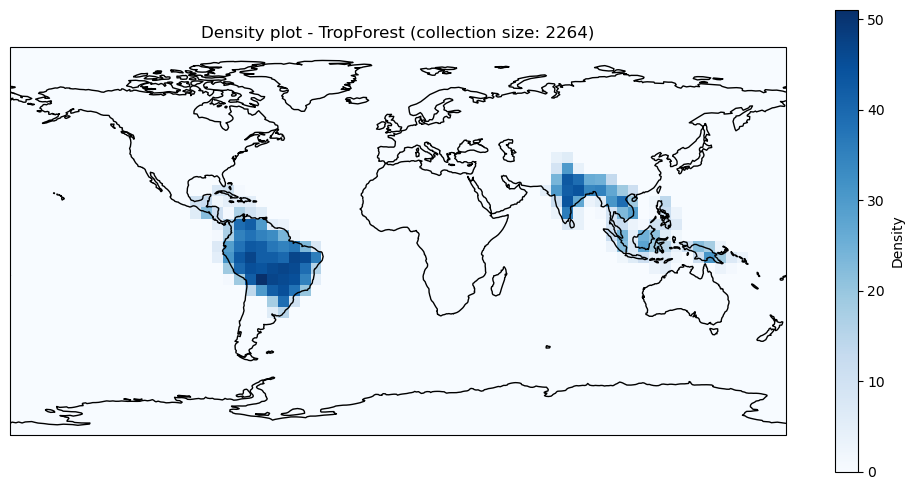

In [8]:
plt.rcParams['figure.figsize'] = [10.00, 5.0]
plt.rcParams['figure.autolayout'] = True

side_x = np.linspace(-180, +180, n_columns)
side_y = np.linspace(-90, +90, n_rows)
X, Y = np.meshgrid(side_x, side_y)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')

plt.pcolormesh(X, Y, Z, shading='auto', cmap='Blues', transform=ccrs.PlateCarree())
plt.colorbar(label='Density')
plt.title("Density plot - " + collection_id + " (collection size: " + str(collection_size) + ")")
plt.show()